# Dependencias

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
class CerebralFlowAnalyzer:
    def __init__(self):
      # Se definen los rangos normales a partir de los datos proporcionados por el estudio
        self.reference_ranges = {
            'male': {
                'under_45': {
                    'internal_carotid_right': (41.28, 61.38),
                    'internal_carotid_left': (40.53, 61.63),
                    'anterior_cerebral_right': (37.69, 55.31),
                    'anterior_cerebral_left': (36.42, 60.42),
                    'middle_cerebral_right': (46.14, 66.20),
                    'middle_cerebral_left': (43.64, 62.66),
                    'posterior_cerebral_right': (30.55, 39.45),
                    'posterior_cerebral_left': (32.44, 50.10)
                },
                'over_45': {
                    'internal_carotid_right': (37.51, 53.89),
                    'internal_carotid_left': (37.71, 64.29),
                    'anterior_cerebral_right': (35.24, 52.96),
                    'anterior_cerebral_left': (33.51, 53.99),
                    'middle_cerebral_right': (42.02, 65.78),
                    'middle_cerebral_left': (46.88, 68.52),
                    'posterior_cerebral_right': (28.77, 42.63),
                    'posterior_cerebral_left': (32.18, 50.62)
                }
            },
            'female': {
                'under_45': {
                    'internal_carotid_right': (43.04, 57.96),
                    'internal_carotid_left': (44.50, 60.24),
                    'anterior_cerebral_right': (38.74, 57.26),
                    'anterior_cerebral_left': (38.70, 64.80),
                    'middle_cerebral_right': (39.29, 80.47),
                    'middle_cerebral_left': (54.51, 87.49),
                    'posterior_cerebral_right': (28.74, 54.98),
                    'posterior_cerebral_left': (30.96, 41.30)
                },
                'over_45': {
                    'internal_carotid_right': (43.92, 67.16),
                    'internal_carotid_left': (37.30, 61.70),
                    'anterior_cerebral_right': (36.12, 52.50),
                    'anterior_cerebral_left': (42.22, 63.18),
                    'middle_cerebral_right': (52.01, 72.15),
                    'middle_cerebral_left': (52.52, 79.06),
                    'posterior_cerebral_right': (34.86, 51.30),
                    'posterior_cerebral_left': (35.93, 54.21)
                }
            }
        }

    def add_realistic_noise(self, value, noise_level=0.05):
        # Función para añadir ruido a los datos
        noise = np.random.normal(0, value * noise_level)
        return value + noise

    def generate_synthetic_data(self, n_samples=1000):
        # Se generan datos con variaciones y ruido
        data = []

        for _ in range(n_samples):
            sex = random.choice(['male', 'female'])
            age = random.randint(20, 80)
            age_group = 'under_45' if age < 45 else 'over_45'

            sample = {
                'age': age,
                'sex': sex
            }

            # Se determina la tendencia general de la muestra
            tendency = random.choice(['normal', 'below', 'above', 'mixed'])

            for artery in self.reference_ranges[sex][age_group].keys():
                min_val, max_val = self.reference_ranges[sex][age_group][artery]
                range_width = max_val - min_val

                if tendency == 'normal':
                    # Se genera un valor dentro del rango normal con alguna varianza
                    base_value = random.uniform(min_val + range_width*0.1, max_val - range_width*0.1)
                elif tendency == 'below':
                    # Se genera un valor por debajo del rango normal
                    base_value = random.uniform(min_val - range_width*0.3, min_val - range_width*0.05)
                elif tendency == 'above':
                    # Se genera un valor por encima del rango normal
                    base_value = random.uniform(max_val + range_width*0.05, max_val + range_width*0.3)
                else:  # mixed
                    # Se hace una elección aleatoria entre un rango normal, por debajo y por encima
                    choice = random.choice(['normal', 'below', 'above'])
                    if choice == 'normal':
                        base_value = random.uniform(min_val + range_width*0.1, max_val - range_width*0.1)
                    elif choice == 'below':
                        base_value = random.uniform(min_val - range_width*0.3, min_val - range_width*0.05)
                    else:
                        base_value = random.uniform(max_val + range_width*0.05, max_val + range_width*0.3)

                # Se añade un ruido a la medición
                value = self.add_realistic_noise(base_value)
                sample[artery] = value

            # Se etiquetan los datos
            label = self.determine_label(sample, sex, age_group)
            sample['label'] = label
            data.append(sample)

        return pd.DataFrame(data)

    def determine_label(self, sample, sex, age_group):
        # Función para determinar la etiqueta de los valores reales
        below_count = 0
        above_count = 0
        normal_count = 0

        for artery in self.reference_ranges[sex][age_group].keys():
            min_val, max_val = self.reference_ranges[sex][age_group][artery]
            value = sample[artery]

            # Se añade algo de difuminación a los límites
            lower_boundary = min_val - (min_val * 0.02)  # 2% por debajo del mínimo valor
            upper_boundary = max_val + (max_val * 0.02)  # 2% por encima del máximo valor

            if value < lower_boundary:
                below_count += 1
            elif value > upper_boundary:
                above_count += 1
            else:
                normal_count += 1

        # Reglas de decisión
        if below_count >= 5:  # Más de la mitad están por debajo
            return 'below'
        elif above_count >= 5:  # Más de la mitad están por encima
            return 'above'
        else:
            return 'normal' # Están dentro del rango normal

    # Se crea el modelo
    def create_model(self, input_shape):

        model = tf.keras.Sequential([
            # Capa de entrada
            tf.keras.Input(shape=input_shape),
            # Capa oculta
            tf.keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            # Capa oculta
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            # Capa oculta
            tf.keras.layers.Dense(32, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            # Capa de salida
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        # Se compila el modelo
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    # Se entrena y evalua el modelo
    def train_and_evaluate(self, n_samples=5000):

        # Se generan y procesan los datos
        print("Generating synthetic data...")
        df = self.generate_synthetic_data(n_samples)

        # División de características y etiquetas
        features = ['age'] + [col for col in df.columns if 'cerebral' in col or 'carotid' in col]
        X = df[features].values
        le_label = LabelEncoder()
        y = le_label.fit_transform(df['label'])

        # División de los datos de entrenamiento, pruebas y validación
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

        # Normalizamos las entradas para que estén en una escala similar
        # Esto es importante para el entrenamiento de esta red neuronal ya que por defecto, las entradas vienen expresadas en escalas diferentes (años, cm/s)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Se crea y se entrena el modelo
        print("Training model...")
        model = self.create_model((X_train.shape[1],))

        # Se añade la posibilidad de una parada temprana
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )

        # Se evalua el modelo
        print("\nEvaluating model...")
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Se generan las predicciones para la matriz de confusión
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Se imprime el reporte de clasificación
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_classes,
                                 target_names=le_label.classes_))

        # Se grafica la matriz de confusion
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=le_label.classes_,
                   yticklabels=le_label.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Se grafica la precisión del modelo
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Se grafica la pérdida del modelo
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

        return model, scaler, le_label

# Visualización de Datos

In [ ]:
datos_fsc = {
    'male': {
        'under_45': {
            'internal_carotid_right':   (41.28,  61.38),
            'internal_carotid_left':    (40.53,  61.63),
            'anterior_cerebral_right':  (37.69,  55.31),
            'anterior_cerebral_left':   (36.42,  60.42),
            'middle_cerebral_right':    (46.14,  66.20),
            'middle_cerebral_left':     (43.64,  62.66),
            'posterior_cerebral_right': (30.55,  39.45),
            'posterior_cerebral_left':  (32.44,  50.10)
        },
        'over_45': {
            'internal_carotid_right':   (37.51,  53.89),
            'internal_carotid_left':    (37.71,  64.29),
            'anterior_cerebral_right':  (35.24,  52.96),
            'anterior_cerebral_left':   (33.51,  53.99),
            'middle_cerebral_right':    (42.02,  65.78),
            'middle_cerebral_left':     (46.88,  68.52),
            'posterior_cerebral_right': (28.77,  42.63),
            'posterior_cerebral_left':  (32.18,  50.62)
        }
    },
    'female': {
        'under_45': {
            'internal_carotid_right':   (43.04,  57.96),
            'internal_carotid_left':    (44.50,  60.24),
            'anterior_cerebral_right':  (38.74,  57.26),
            'anterior_cerebral_left':   (38.70,  64.80),
            'middle_cerebral_right':    (39.29,  80.47),
            'middle_cerebral_left':     (54.51,  87.49),
            'posterior_cerebral_right': (28.74,  54.98),
            'posterior_cerebral_left':  (30.96,  41.30)
        },
        'over_45': {
            'internal_carotid_right':   (43.92,  67.16),
            'internal_carotid_left':    (37.30,  61.70),
            'anterior_cerebral_right':  (36.12,  52.50),
            'anterior_cerebral_left':   (42.22,  63.18),
            'middle_cerebral_right':    (52.01,  72.15),
            'middle_cerebral_left':     (52.52,  79.06),
            'posterior_cerebral_right': (34.86,  51.30),
            'posterior_cerebral_left':  (35.93,  54.21)
        }
    }
}

# entrenamiento 64% / validación 16% / prueba 20%

print("Etiqueta Categórica: [0 1 0]")
print("                        ↑normal\n\n")

print("Posible Predicción : [0.054  0.901  0.045]")
print("                                ↑")
print("                            elección\n\n")

# ruido de 5%

Etiqueta Categórica: [0 1 0]
                        ↑normal


Posible Predicción : [0.054  0.901  0.045]
                                ↑
                            elección




# Estructura del Modelo

In [ ]:
tf.keras.Sequential([
    tf.keras.Input(shape=(9,)),
    tf.keras.layers.Dense(128, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
]).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,611 (49.26 KB)

 Trainable params: 12,163 (47.51 KB)

 Non-trainable params: 448 (1.75 KB)

# Optimizador y Función de Pérdida

In [ ]:
modelo_ejemplo = tf.keras.models.Model()
modelo_ejemplo.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

# Entrenamiento y Pruebas

Generating synthetic data...
Training model...
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7276 - loss: 2.1261 - val_accuracy: 0.9463 - val_loss: 1.5919
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9248 - loss: 1.4639 - val_accuracy: 0.9513 - val_loss: 1.2634
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - loss: 1.2145 - val_accuracy: 0.9525 - val_loss: 1.0340
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9274 - loss: 1.0093 - val_accuracy: 0.9513 - val_loss: 0.8551
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9271 - loss: 0.8670 - val_accuracy: 0.9463 - val_loss: 0.7181
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9403 - loss: 0.7244 - val_accuracy: 0.9413 - val_loss: 0.6194
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.6081 - val_accuracy: 0.9438 - val_loss: 0.5389
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

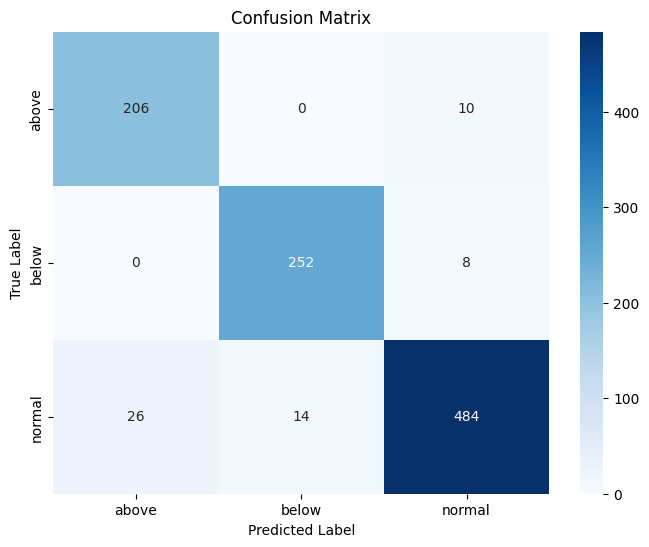

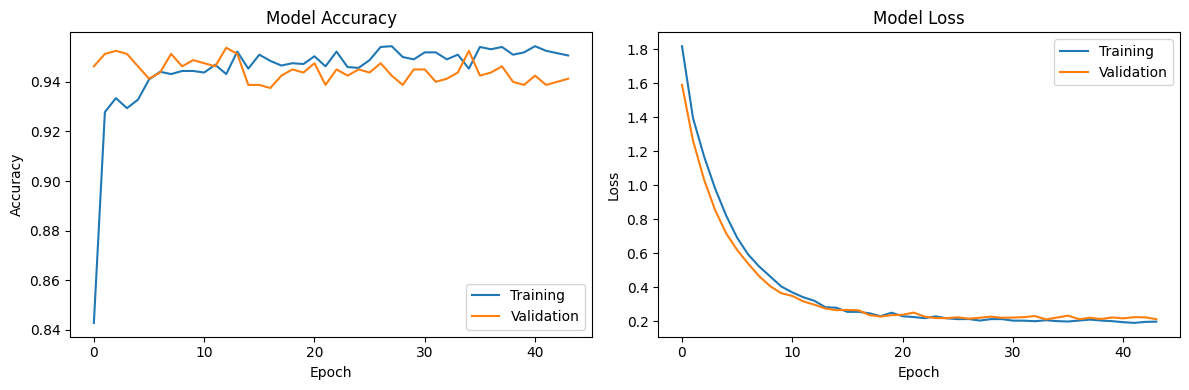

In [ ]:
def main():
    analyzer = CerebralFlowAnalyzer()
    model, scaler, le_label = analyzer.train_and_evaluate(n_samples=5000)

if __name__ == "__main__":
    main()